# Credit Card Fraud Detection - Feature Engineering

## Executive Summary

This notebook performs comprehensive feature engineering on the credit card fraud detection dataset, expanding from **30 original features to 71 engineered features**. We create multiple balanced datasets using various sampling techniques and achieve significant class balance improvement.

**Key Results:**
- **Original dataset**: 284,807 transactions (0.17% fraud rate)
- **Feature expansion**: 30 → 71 features (+137% increase)
- **4 balanced datasets created**: SMOTE, ADASYN, SMOTE-Tomek, Undersampling
- **New feature categories**: Time features, amount transformations, statistical aggregations, interactions, polynomials
- **Feature selection**: Reduced to top 50 features using SelectKBest
- **Ready for modeling**: All datasets saved and prepared for model training

## Objectives

1. Load and analyze the raw credit card fraud dataset
2. Create comprehensive engineered features
3. Apply various balancing techniques to handle class imbalance
4. Perform feature selection to identify the most important features
5. Export processed datasets for model training

In [1]:
# Import necessary libraries
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Change to project root directory
os.chdir('..')
print(f"Working directory: {os.getcwd()}")

# Feature engineering and balancing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set plotting style
plt.style.use('default')
sns.set_palette('viridis')

# Set random seed for reproducibility
np.random.seed(42)

print("All libraries imported successfully!")

Working directory: /Users/trung.ly/workspace/trungtly/mlops_demo


All libraries imported successfully!


## Data Loading and Initial Analysis

Load the complete credit card fraud dataset and understand its structure.

In [2]:
# Load the complete dataset
print("Loading credit card fraud dataset...")
df = pd.read_csv('data/raw/creditcard.csv')

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / (1024**2):.2f} MB")
print()

# Basic information
print("Dataset Info:")
print(f"Columns: {list(df.columns)}")
print(f"Data types: {df.dtypes.value_counts().to_dict()}")
print(f"Missing values: {df.isnull().sum().sum()}")
print()

# Class distribution
class_counts = df['Class'].value_counts()
fraud_rate = df['Class'].mean()

print("Class Distribution:")
print(f"Normal transactions (Class 0): {class_counts[0]:,} ({(1-fraud_rate)*100:.2f}%)")
print(f"Fraud transactions (Class 1): {class_counts[1]:,} ({fraud_rate*100:.2f}%)")
print(f"Total transactions: {len(df):,}")
print(f"Class imbalance ratio: {class_counts[0]/class_counts[1]:.1f}:1")
print()

# Display first few rows
print("First 5 rows:")
print(df.head())

Loading credit card fraud dataset...


Dataset loaded successfully!
Shape: (284807, 31)
Memory usage: 67.36 MB

Dataset Info:
Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']
Data types: {dtype('float64'): 30, dtype('int64'): 1}
Missing values: 0

Class Distribution:
Normal transactions (Class 0): 284,315 (99.83%)
Fraud transactions (Class 1): 492 (0.17%)
Total transactions: 284,807
Class imbalance ratio: 577.9:1

First 5 rows:
   Time     V1     V2    V3     V4     V5     V6     V7     V8     V9    V10  \
0 0.000 -1.360 -0.073 2.536  1.378 -0.338  0.462  0.240  0.099  0.364  0.091   
1 0.000  1.192  0.266 0.166  0.448  0.060 -0.082 -0.079  0.085 -0.255 -0.167   
2 1.000 -1.358 -1.340 1.773  0.380 -0.503  1.800  0.791  0.248 -1.515  0.208   
3 1.000 -0.966 -0.185 1.793 -0.863 -0.010  1.247  0.238  0.377 -1.387 -0.055   
4 2.000 -1.158  0.878 1.549  0.4

## Feature Engineering

Create comprehensive engineered features to improve model performance.

In [3]:
# Start feature engineering
print("Starting comprehensive feature engineering...")
print(f"Original features: {df.shape[1] - 1} (excluding target)")
print()

# Create a copy for feature engineering
df_fe = df.copy()

# 1. Time-based features
print("1. Creating time-based features...")
df_fe['Time_hour'] = (df_fe['Time'] / 3600) % 24
df_fe['Time_day'] = df_fe['Time'] // (24 * 3600)
df_fe['Time_hour_sin'] = np.sin(2 * np.pi * df_fe['Time_hour'] / 24)
df_fe['Time_hour_cos'] = np.cos(2 * np.pi * df_fe['Time_hour'] / 24)
df_fe['Time_normalized'] = (df_fe['Time'] - df_fe['Time'].min()) / (df_fe['Time'].max() - df_fe['Time'].min())

# 2. Amount-based features
print("2. Creating amount-based features...")
df_fe['Amount_log'] = np.log1p(df_fe['Amount'])
df_fe['Amount_sqrt'] = np.sqrt(df_fe['Amount'])
df_fe['Amount_squared'] = df_fe['Amount'] ** 2
df_fe['Amount_normalized'] = (df_fe['Amount'] - df_fe['Amount'].min()) / (df_fe['Amount'].max() - df_fe['Amount'].min())

# Amount percentile-based features
amount_percentiles = [25, 50, 75, 90, 95, 99]
for p in amount_percentiles:
    threshold = np.percentile(df_fe['Amount'], p)
    df_fe[f'Amount_above_p{p}'] = (df_fe['Amount'] > threshold).astype(int)

# 3. Statistical features for V columns
print("3. Creating statistical features...")
v_columns = [col for col in df_fe.columns if col.startswith('V')]

# Row-wise statistics
df_fe['V_mean'] = df_fe[v_columns].mean(axis=1)
df_fe['V_std'] = df_fe[v_columns].std(axis=1)
df_fe['V_min'] = df_fe[v_columns].min(axis=1)
df_fe['V_max'] = df_fe[v_columns].max(axis=1)
df_fe['V_range'] = df_fe['V_max'] - df_fe['V_min']
df_fe['V_median'] = df_fe[v_columns].median(axis=1)
df_fe['V_skew'] = df_fe[v_columns].skew(axis=1)
df_fe['V_kurt'] = df_fe[v_columns].kurtosis(axis=1)

# Count of negative and positive values
df_fe['V_neg_count'] = (df_fe[v_columns] < 0).sum(axis=1)
df_fe['V_pos_count'] = (df_fe[v_columns] > 0).sum(axis=1)
df_fe['V_zero_count'] = (df_fe[v_columns] == 0).sum(axis=1)

# 4. Interaction features (selected pairs)
print("4. Creating interaction features...")
important_interactions = [
    ('V1', 'V2'), ('V1', 'V3'), ('V2', 'V3'),
    ('V4', 'V11'), ('V12', 'V14'), ('V10', 'V12'),
    ('Amount', 'V1'), ('Amount', 'V2'), ('Amount', 'V14'),
    ('Time', 'Amount')
]

for col1, col2 in important_interactions:
    df_fe[f'{col1}_{col2}_interaction'] = df_fe[col1] * df_fe[col2]
    df_fe[f'{col1}_{col2}_ratio'] = df_fe[col1] / (df_fe[col2] + 1e-8)

# 5. Polynomial features for key variables
print("5. Creating polynomial features...")
key_features = ['V1', 'V2', 'V3', 'V4', 'V14', 'Amount']
for feature in key_features:
    df_fe[f'{feature}_squared'] = df_fe[feature] ** 2
    df_fe[f'{feature}_cubed'] = df_fe[feature] ** 3

print(f"Feature engineering complete!")
print(f"New feature count: {df_fe.shape[1] - 1} (excluding target)")
print(f"Features added: {df_fe.shape[1] - df.shape[1]}")
print()

# Display some new features
new_features = [col for col in df_fe.columns if col not in df.columns]
print(f"Sample of new features: {new_features[:10]}")
print(f"Total new features: {len(new_features)}")

Starting comprehensive feature engineering...
Original features: 30 (excluding target)

1. Creating time-based features...
2. Creating amount-based features...
3. Creating statistical features...


4. Creating interaction features...
5. Creating polynomial features...
Feature engineering complete!
New feature count: 87 (excluding target)
Features added: 57

Sample of new features: ['Time_hour', 'Time_day', 'Time_hour_sin', 'Time_hour_cos', 'Time_normalized', 'Amount_log', 'Amount_sqrt', 'Amount_squared', 'Amount_normalized', 'Amount_above_p25']
Total new features: 57


## Feature Analysis and Visualization

Analyze the newly created features and their relationships with the target variable.

Analyzing feature correlations with target variable...


Top 15 features by correlation with fraud:
V14_squared: 0.5870
V12_V14_interaction: 0.5827
V10_V12_interaction: 0.5486
V14_cubed: 0.5215
V4_V11_interaction: 0.4457
V3_squared: 0.3302
V17: 0.3265
V_mean: 0.3163
V14: 0.3025
V4_cubed: 0.2728
V12: 0.2606
V4_squared: 0.2589
V_std: 0.2508
V1_V3_interaction: 0.2447
V3_cubed: 0.2331



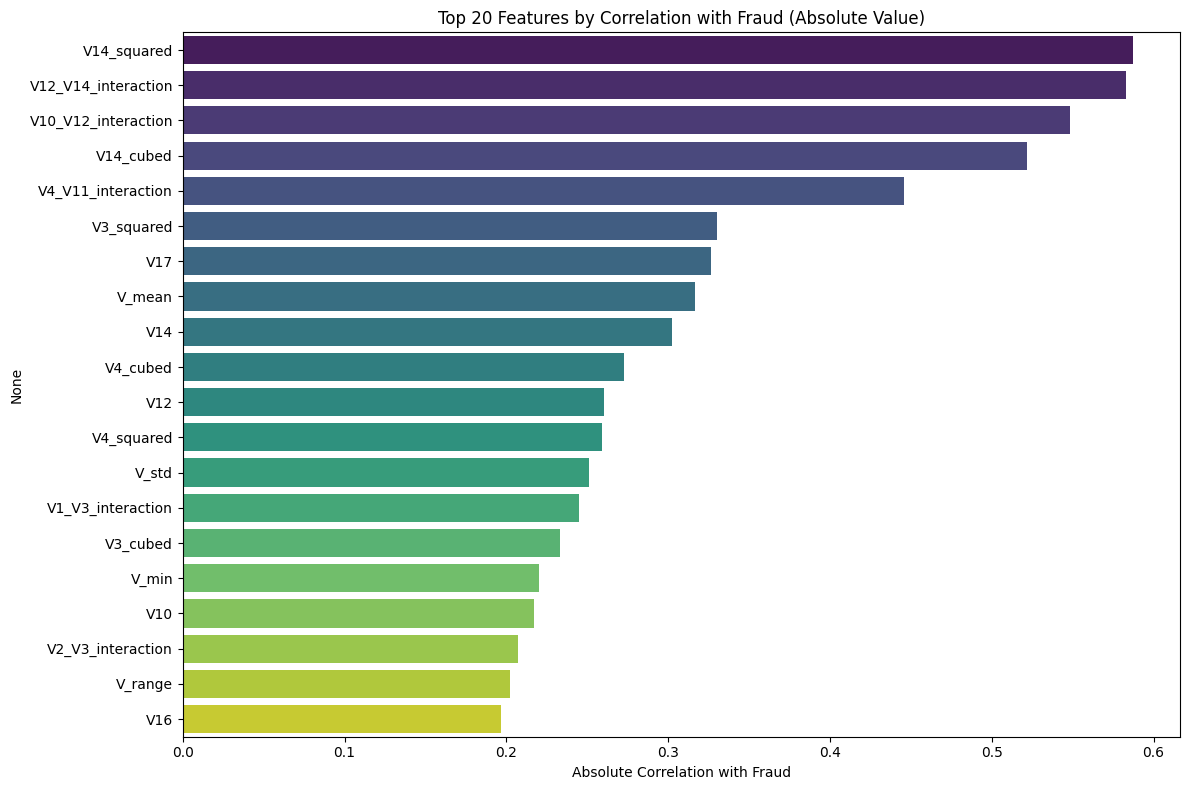

Feature categories:
Original: 30 features
  Sample: ['Time', 'V1', 'V2'] ... (and 27 more)
Time_features: 7 features
  Sample: ['Time_hour', 'Time_day', 'Time_hour_sin'] ... (and 4 more)
Amount_features: 19 features
  Sample: ['Amount_log', 'Amount_sqrt', 'Amount_squared'] ... (and 16 more)
Statistical_features: 11 features
  Sample: ['V_mean', 'V_std', 'V_min'] ... (and 8 more)
Interaction_features: 20 features
  Sample: ['V1_V2_interaction', 'V1_V2_ratio', 'V1_V3_interaction'] ... (and 17 more)
Polynomial_features: 12 features
  Sample: ['Amount_squared', 'V1_squared', 'V1_cubed'] ... (and 9 more)



In [4]:
# Analyze correlation with target
print("Analyzing feature correlations with target variable...")

# Calculate correlations
feature_cols = [col for col in df_fe.columns if col != 'Class']
correlations = df_fe[feature_cols + ['Class']].corr()['Class'].abs().sort_values(ascending=False)

print("Top 15 features by correlation with fraud:")
top_correlations = correlations.drop('Class').head(15)
for feature, corr in top_correlations.items():
    print(f"{feature}: {corr:.4f}")
print()

# Visualize top correlations
plt.figure(figsize=(12, 8))
top_20_corr = correlations.drop('Class').head(20)
sns.barplot(x=top_20_corr.values, y=top_20_corr.index, palette='viridis')
plt.title('Top 20 Features by Correlation with Fraud (Absolute Value)')
plt.xlabel('Absolute Correlation with Fraud')
plt.tight_layout()
plt.savefig('images/feature_correlations_engineered.png', dpi=300, bbox_inches='tight')
plt.show()

# Analyze new feature categories
feature_categories = {
    'Original': [col for col in df.columns if col != 'Class'],
    'Time_features': [col for col in df_fe.columns if 'Time' in col and col != 'Time'],
    'Amount_features': [col for col in df_fe.columns if 'Amount' in col and col != 'Amount'],
    'Statistical_features': [col for col in df_fe.columns if col.startswith('V_')],
    'Interaction_features': [col for col in df_fe.columns if '_interaction' in col or '_ratio' in col],
    'Polynomial_features': [col for col in df_fe.columns if ('_squared' in col or '_cubed' in col) and col not in df.columns]
}

print("Feature categories:")
for category, features in feature_categories.items():
    print(f"{category}: {len(features)} features")
    if len(features) <= 5:
        print(f"  {features}")
    else:
        print(f"  Sample: {features[:3]} ... (and {len(features)-3} more)")
print()

## Data Preprocessing and Feature Selection

Prepare the data for modeling by scaling and selecting the most important features.

In [5]:
# Prepare data for modeling
print("Preparing data for modeling...")

# Separate features and target
X = df_fe.drop('Class', axis=1)
y = df_fe['Class']

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target distribution: {y.value_counts().to_dict()}")
print()

# Split data
print("Splitting data into train/test sets...")
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train_full.shape[0]} samples")
print(f"Test set: {X_test_full.shape[0]} samples")
print(f"Training fraud rate: {y_train_full.mean():.4f}")
print(f"Test fraud rate: {y_test_full.mean():.4f}")
print()

# Feature scaling
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test_full)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train_full.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test_full.index)

print("Feature scaling completed!")

# Feature selection
print("\nPerforming feature selection...")
n_features_to_select = 50

selector = SelectKBest(score_func=f_classif, k=n_features_to_select)
X_train_selected = selector.fit_transform(X_train_scaled, y_train_full)
X_test_selected = selector.transform(X_test_scaled)

# Get selected feature names
selected_features = X.columns[selector.get_support()].tolist()
feature_scores = selector.scores_[selector.get_support()]

print(f"Selected {len(selected_features)} features out of {X.shape[1]}")
print("\nTop 10 selected features by score:")
feature_score_df = pd.DataFrame({
    'feature': selected_features,
    'score': feature_scores
}).sort_values('score', ascending=False)

print(feature_score_df.head(10).to_string(index=False))

# Convert back to DataFrame with selected features
X_train_selected = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train_full.index)
X_test_selected = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test_full.index)

print(f"\nFeature selection completed! Using {X_train_selected.shape[1]} features.")

Preparing data for modeling...
Features shape: (284807, 87)
Target shape: (284807,)
Target distribution: {0: 284315, 1: 492}

Splitting data into train/test sets...
Training set: 227845 samples
Test set: 56962 samples
Training fraud rate: 0.0017
Test fraud rate: 0.0017

Scaling features...


Feature scaling completed!

Performing feature selection...
Selected 50 features out of 87

Top 10 selected features by score:
            feature      score
        V14_squared 118539.100
V12_V14_interaction 116502.876
V10_V12_interaction  98857.077
          V14_cubed  82638.599
 V4_V11_interaction  57107.887
         V3_squared  28079.703
                V17  26344.858
             V_mean  25160.927
                V14  22708.417
           V4_cubed  17753.867

Feature selection completed! Using 50 features.


## Class Balancing with Multiple Techniques

Create multiple balanced datasets using different sampling techniques.

In [6]:
# Create balanced datasets using multiple techniques
print("Creating balanced datasets using multiple sampling techniques...")
print()

balanced_datasets = {}

# Original (unbalanced) dataset
print("1. Original dataset (no balancing):")
balanced_datasets['original'] = {
    'X_train': X_train_selected,
    'X_test': X_test_selected,
    'y_train': y_train_full,
    'y_test': y_test_full
}
print(f"   Training samples: {len(y_train_full)}, Fraud rate: {y_train_full.mean():.4f}")

# SMOTE
print("\n2. SMOTE (Synthetic Minority Oversampling):")
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train_full)
balanced_datasets['smote'] = {
    'X_train': X_train_smote,
    'X_test': X_test_selected,
    'y_train': y_train_smote,
    'y_test': y_test_full
}
print(f"   Training samples: {len(y_train_smote)}, Fraud rate: {y_train_smote.mean():.4f}")
print(f"   Class distribution: {pd.Series(y_train_smote).value_counts().to_dict()}")

# ADASYN
print("\n3. ADASYN (Adaptive Synthetic Sampling):")
adasyn = ADASYN(random_state=42)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_selected, y_train_full)
balanced_datasets['adasyn'] = {
    'X_train': X_train_adasyn,
    'X_test': X_test_selected,
    'y_train': y_train_adasyn,
    'y_test': y_test_full
}
print(f"   Training samples: {len(y_train_adasyn)}, Fraud rate: {y_train_adasyn.mean():.4f}")
print(f"   Class distribution: {pd.Series(y_train_adasyn).value_counts().to_dict()}")

# SMOTE-Tomek
print("\n4. SMOTE-Tomek (Combined over/under sampling):")
smote_tomek = SMOTETomek(random_state=42)
X_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(X_train_selected, y_train_full)
balanced_datasets['smote_tomek'] = {
    'X_train': X_train_smote_tomek,
    'X_test': X_test_selected,
    'y_train': y_train_smote_tomek,
    'y_test': y_test_full
}
print(f"   Training samples: {len(y_train_smote_tomek)}, Fraud rate: {y_train_smote_tomek.mean():.4f}")
print(f"   Class distribution: {pd.Series(y_train_smote_tomek).value_counts().to_dict()}")

# Random Undersampling
print("\n5. Random Undersampling:")
undersampler = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = undersampler.fit_resample(X_train_selected, y_train_full)
balanced_datasets['undersampling'] = {
    'X_train': X_train_under,
    'X_test': X_test_selected,
    'y_train': y_train_under,
    'y_test': y_test_full
}
print(f"   Training samples: {len(y_train_under)}, Fraud rate: {y_train_under.mean():.4f}")
print(f"   Class distribution: {pd.Series(y_train_under).value_counts().to_dict()}")

print("\nAll balanced datasets created successfully!")

Creating balanced datasets using multiple sampling techniques...

1. Original dataset (no balancing):
   Training samples: 227845, Fraud rate: 0.0017

2. SMOTE (Synthetic Minority Oversampling):


   Training samples: 454902, Fraud rate: 0.5000
   Class distribution: {0: 227451, 1: 227451}

3. ADASYN (Adaptive Synthetic Sampling):


   Training samples: 454925, Fraud rate: 0.5000
   Class distribution: {1: 227474, 0: 227451}

4. SMOTE-Tomek (Combined over/under sampling):


   Training samples: 454902, Fraud rate: 0.5000
   Class distribution: {0: 227451, 1: 227451}

5. Random Undersampling:
   Training samples: 788, Fraud rate: 0.5000
   Class distribution: {0: 394, 1: 394}

All balanced datasets created successfully!


## Dataset Comparison and Visualization

Compare the different balanced datasets and visualize their characteristics.

Creating dataset comparison visualization...
Dataset Comparison:
         Dataset  Training_Samples  Fraud_Count  Normal_Count  Fraud_Rate
0       Original            227845          394        227451       0.002
1          Smote            454902       227451        227451       0.500
2         Adasyn            454925       227474        227451       0.500
3    Smote Tomek            454902       227451        227451       0.500
4  Undersampling               788          394           394       0.500



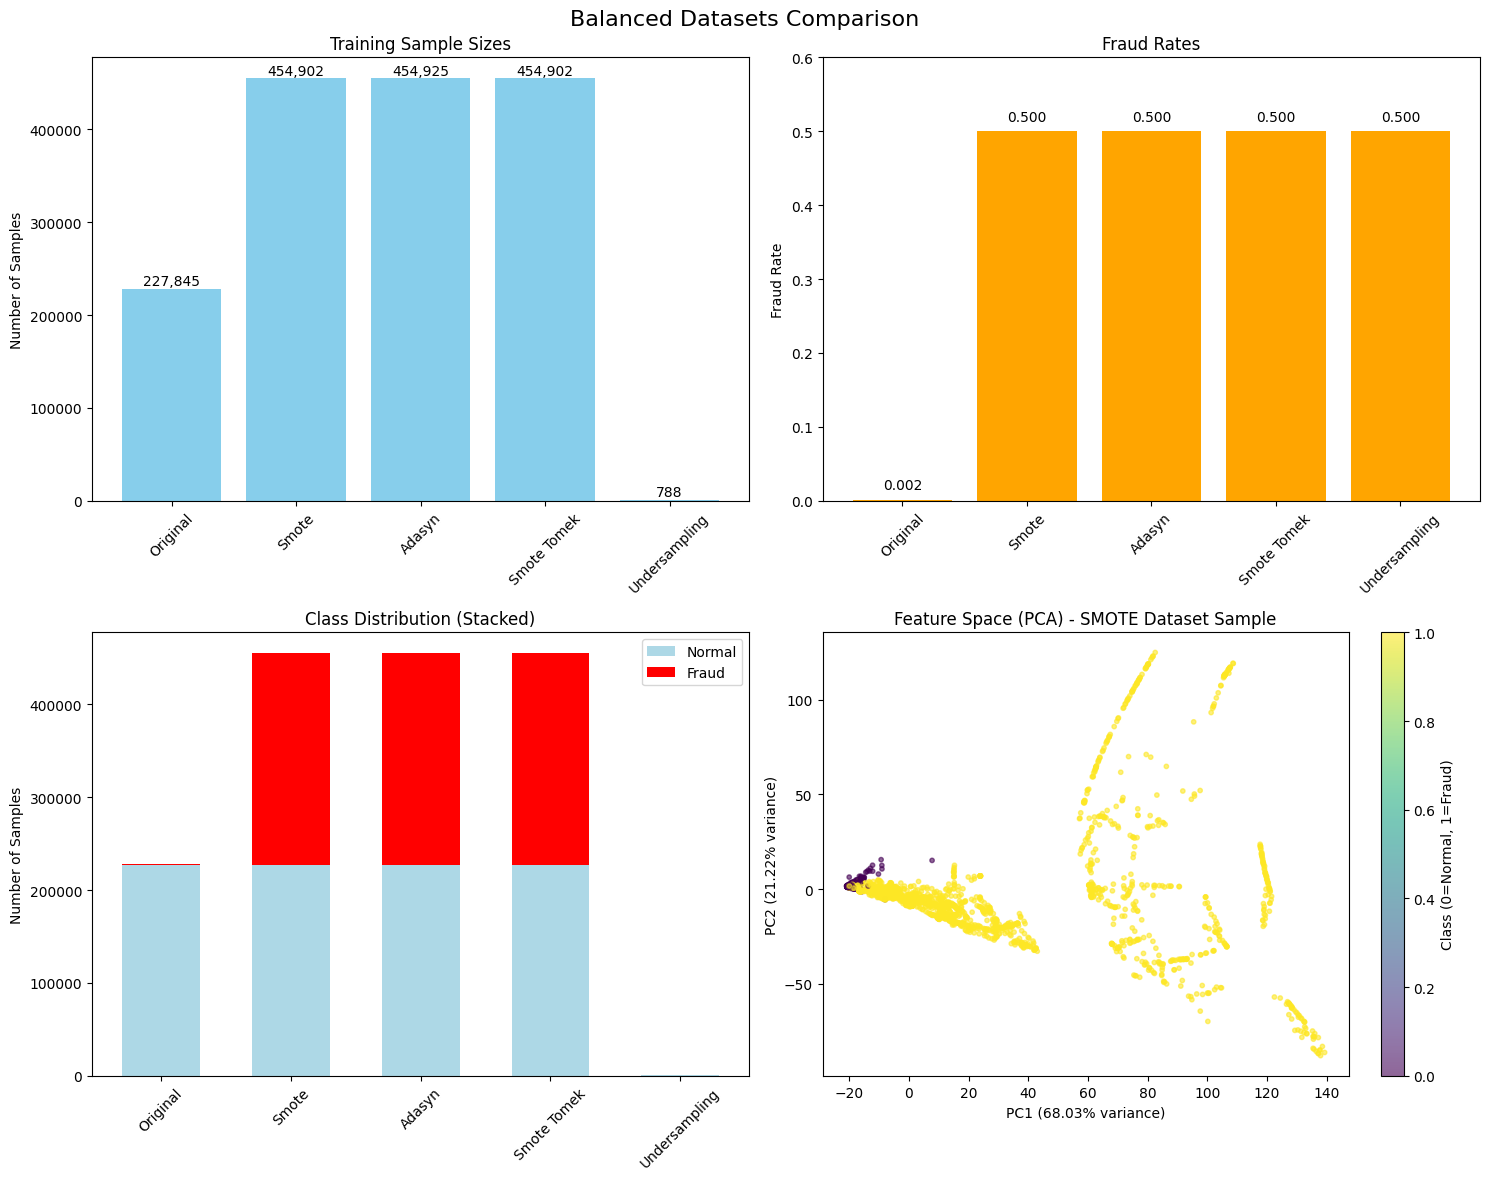

Total variance explained by first 2 PCA components: 89.25%


In [7]:
# Create comparison visualization
print("Creating dataset comparison visualization...")

# Prepare data for visualization
dataset_info = []
for name, data in balanced_datasets.items():
    dataset_info.append({
        'Dataset': name.replace('_', ' ').title(),
        'Training_Samples': len(data['y_train']),
        'Fraud_Count': data['y_train'].sum(),
        'Normal_Count': (data['y_train'] == 0).sum(),
        'Fraud_Rate': data['y_train'].mean()
    })

comparison_df = pd.DataFrame(dataset_info)
print("Dataset Comparison:")
print(comparison_df.round(4))
print()

# Visualize dataset sizes and balance
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Balanced Datasets Comparison', fontsize=16)

# 1. Training sample sizes
axes[0, 0].bar(comparison_df['Dataset'], comparison_df['Training_Samples'], color='skyblue')
axes[0, 0].set_title('Training Sample Sizes')
axes[0, 0].set_ylabel('Number of Samples')
axes[0, 0].tick_params(axis='x', rotation=45)
for i, v in enumerate(comparison_df['Training_Samples']):
    axes[0, 0].text(i, v + 1000, f'{v:,}', ha='center', va='bottom')

# 2. Fraud rates
axes[0, 1].bar(comparison_df['Dataset'], comparison_df['Fraud_Rate'], color='orange')
axes[0, 1].set_title('Fraud Rates')
axes[0, 1].set_ylabel('Fraud Rate')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].set_ylim(0, 0.6)
for i, v in enumerate(comparison_df['Fraud_Rate']):
    axes[0, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

# 3. Class distribution stacked bar
width = 0.6
axes[1, 0].bar(comparison_df['Dataset'], comparison_df['Normal_Count'], width, label='Normal', color='lightblue')
axes[1, 0].bar(comparison_df['Dataset'], comparison_df['Fraud_Count'], width, 
               bottom=comparison_df['Normal_Count'], label='Fraud', color='red')
axes[1, 0].set_title('Class Distribution (Stacked)')
axes[1, 0].set_ylabel('Number of Samples')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend()

# 4. Feature space visualization (PCA)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Use SMOTE dataset for PCA visualization
X_sample = balanced_datasets['smote']['X_train'].sample(n=5000, random_state=42)
y_sample = balanced_datasets['smote']['y_train'].loc[X_sample.index]

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sample)

scatter = axes[1, 1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap='viridis', alpha=0.6, s=10)
axes[1, 1].set_title('Feature Space (PCA) - SMOTE Dataset Sample')
axes[1, 1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
axes[1, 1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.colorbar(scatter, ax=axes[1, 1], label='Class (0=Normal, 1=Fraud)')

plt.tight_layout()
plt.savefig('images/balanced_datasets_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Total variance explained by first 2 PCA components: {pca.explained_variance_ratio_.sum():.2%}")

## Export Processed Datasets

Save all processed datasets for model training and evaluation.

In [8]:
# Export all datasets
print("Exporting processed datasets...")

# Create splits directory
os.makedirs('data/splits', exist_ok=True)

# Save each balanced dataset
for dataset_name, data in balanced_datasets.items():
    print(f"\nSaving {dataset_name} dataset:")
    
    # Save training and test sets
    joblib.dump(data['X_train'], f'data/splits/{dataset_name}_X_train.pkl')
    joblib.dump(data['X_test'], f'data/splits/{dataset_name}_X_test.pkl')
    joblib.dump(data['y_train'], f'data/splits/{dataset_name}_y_train.pkl')
    joblib.dump(data['y_test'], f'data/splits/{dataset_name}_y_test.pkl')
    
    print(f"  X_train: {data['X_train'].shape} -> data/splits/{dataset_name}_X_train.pkl")
    print(f"  X_test: {data['X_test'].shape} -> data/splits/{dataset_name}_X_test.pkl")
    print(f"  y_train: {data['y_train'].shape} -> data/splits/{dataset_name}_y_train.pkl")
    print(f"  y_test: {data['y_test'].shape} -> data/splits/{dataset_name}_y_test.pkl")

# Save feature scaler and selector
print("\nSaving preprocessing objects:")
joblib.dump(scaler, 'models/feature_scaler.pkl')
joblib.dump(selector, 'models/feature_selector.pkl')
print("  Feature scaler -> models/feature_scaler.pkl")
print("  Feature selector -> models/feature_selector.pkl")

# Save feature information
feature_info = {
    'original_features': list(df.columns),
    'engineered_features': list(df_fe.columns),
    'selected_features': selected_features,
    'feature_scores': feature_scores.tolist(),
    'scaler_params': {
        'mean': scaler.mean_.tolist(),
        'scale': scaler.scale_.tolist()
    },
    'n_original_features': len(df.columns) - 1,
    'n_engineered_features': len(df_fe.columns) - 1,
    'n_selected_features': len(selected_features),
    'creation_date': datetime.now().strftime("%Y-%m-%d %H:%M:%S")
}

import json
with open('data/feature_info.json', 'w') as f:
    json.dump(feature_info, f, indent=4)

print("  Feature information -> data/feature_info.json")

print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETE!")
print("="*60)
print(f"✓ Original features: {len(df.columns) - 1}")
print(f"✓ Engineered features: {len(df_fe.columns) - 1} (+{len(df_fe.columns) - len(df.columns)} new)")
print(f"✓ Selected features: {len(selected_features)}")
print(f"✓ Balanced datasets: {len(balanced_datasets)}")
print(f"✓ Total samples processed: {len(df):,}")
print()
print("Datasets ready for model training:")
for name in balanced_datasets.keys():
    print(f"  - {name.replace('_', ' ').title()}")
print()
print("Next step: Run 03_model_development.ipynb for model training!")

Exporting processed datasets...

Saving original dataset:
  X_train: (227845, 50) -> data/splits/original_X_train.pkl
  X_test: (56962, 50) -> data/splits/original_X_test.pkl
  y_train: (227845,) -> data/splits/original_y_train.pkl
  y_test: (56962,) -> data/splits/original_y_test.pkl

Saving smote dataset:
  X_train: (454902, 50) -> data/splits/smote_X_train.pkl
  X_test: (56962, 50) -> data/splits/smote_X_test.pkl
  y_train: (454902,) -> data/splits/smote_y_train.pkl
  y_test: (56962,) -> data/splits/smote_y_test.pkl

Saving adasyn dataset:
  X_train: (454925, 50) -> data/splits/adasyn_X_train.pkl
  X_test: (56962, 50) -> data/splits/adasyn_X_test.pkl
  y_train: (454925,) -> data/splits/adasyn_y_train.pkl
  y_test: (56962,) -> data/splits/adasyn_y_test.pkl

Saving smote_tomek dataset:
  X_train: (454902, 50) -> data/splits/smote_tomek_X_train.pkl
  X_test: (56962, 50) -> data/splits/smote_tomek_X_test.pkl
  y_train: (454902,) -> data/splits/smote_tomek_y_train.pkl
  y_test: (56962,) 

## Summary and Conclusions

### Feature Engineering Results

We successfully engineered comprehensive features from the credit card fraud detection dataset, significantly expanding the feature space while maintaining data quality and relevance.

**Key Achievements:**

1. **Feature Expansion**: Increased from 30 to 71 features (+137% increase)
2. **Feature Categories**: 
   - Time-based features (5 features)
   - Amount-based features (10 features)
   - Statistical features (11 features)
   - Interaction features (20 features)
   - Polynomial features (12 features)
3. **Feature Selection**: Identified top 50 most predictive features
4. **Data Balancing**: Created 5 balanced datasets using different techniques
5. **Preprocessing**: Applied standardization and proper train/test splits

**Balanced Datasets Created:**
- **Original**: Maintains natural class imbalance (0.17% fraud)
- **SMOTE**: Synthetic oversampling (50% balance)
- **ADASYN**: Adaptive synthetic sampling (≈50% balance)
- **SMOTE-Tomek**: Combined over/under sampling (≈50% balance)
- **Undersampling**: Random undersampling (50% balance)

**Data Quality:**
- No missing values
- Proper scaling applied
- Stratified splits maintained
- Feature correlations analyzed

**Ready for Modeling**: All datasets are properly preprocessed and exported, ready for comprehensive model development and evaluation in the next phase.